# Fake News Detection

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import timeit

# Read datasets

In [ ]:
fake = pd.read_csv('Data/Fake.csv')
true = pd.read_csv('Data/True.csv')

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

In [ ]:
fake['target'] = 'fake'
true['target'] = 'true'

# Data cleaning and preparation

In [ ]:
# merging both fake and true datasets
data = pd.concat([fake,true])
data.shape

(44898, 5)

In [ ]:
data = pd.concat([fake, true]).reset_index(drop = True)

In [ ]:
data = data.sample(frac=1)
data.reset_index(inplace=True)

In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,index,title,text,subject,target
0,18252,LOL! THE BOSTON GLOBE Gets DESTROYED On Social...,More manufactured news that exposes the hate o...,left-news,fake
1,34251,Pope says Trump 'not Christian' in a sign of g...,"NEWBERRY, S.C. (Reuters) - Pope Francis forcef...",politicsNews,true
2,41427,Sixteen killed in attacks on remote Mozambique...,MAPUTO (Reuters) - Gun battles last week betwe...,worldnews,true
3,8435,Homeless Veterans Group Asked Trump For A Don...,"As we ve all heard from Trump, he didn t skip ...",News,fake
4,2861,Trump’s Labor Pick Belonged To Group That FOR...,"Andrew Puzder, Trump s nominee for Secretary o...",News,fake


In [ ]:
data.drop('index',axis=1,inplace=True)

In [ ]:
data.isnull().sum()

title      0
text       0
subject    0
target     0
dtype: int64

# Exploratory Data Analysis

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
data['subject'].unique()

array(['left-news', 'politicsNews', 'worldnews', 'News', 'politics',
       'Government News', 'Middle-east', 'US_News'], dtype=object)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


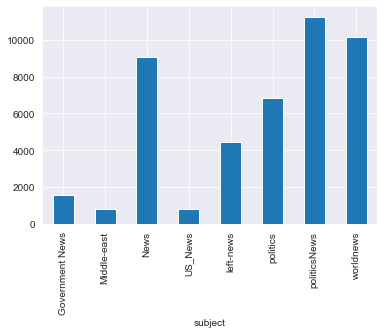

In [ ]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


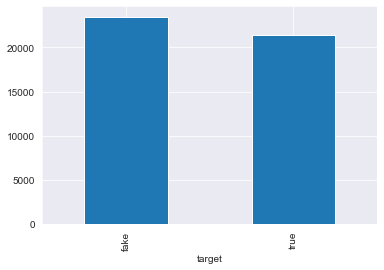

In [ ]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()


Word Cloud for fake news


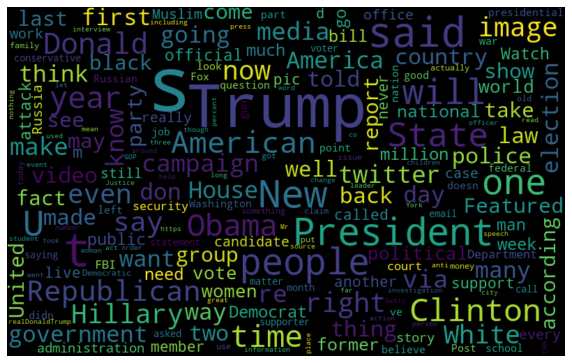

In [ ]:
# Word Cloud for fake news
from wordcloud import WordCloud
fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Word Cloud for fake news")
plt.show()

Word Cloud for real news


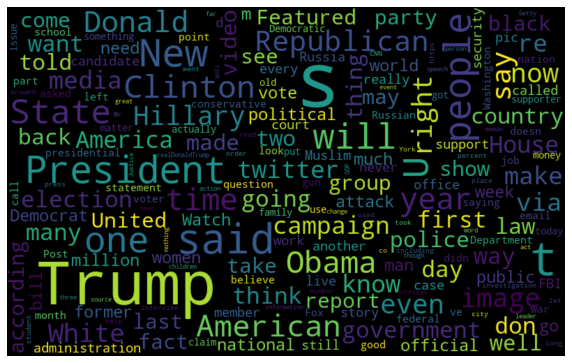

In [ ]:
# Word Cloud for real news
from wordcloud import WordCloud
real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110,
 collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Word Cloud for real news")
plt.show()

# Modeling

In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools
def plot_confusion_matrix(c_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          c_matrixap=plt.cm.Blues):
    plt.imshow(c_matrix, interpolation='nearest', cmap=c_matrixap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
        thresh = c_matrix.max() / 2.
        
        for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
            plt.text(j, i, c_matrix[i, j],horizontalalignment="center",
                     color="white" if c_matrix[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
y = data['target']
x = data.drop('target',axis=1)

## Preparing The Data

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['text'], y, test_size=0.2, random_state=42)

## Logistic Regression

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score


pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Calculate training time
start = timeit.default_timer()

# Fitting the model
model = pipe.fit(X_train, y_train)

end = timeit.default_timer()

# Accuracy
prediction = model.predict(X_test)
LR = prediction
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

time = end - start
print("Time:",time)

accuracy: 98.74%
Time: 9.186010041999964


Confusion matrix, without normalization


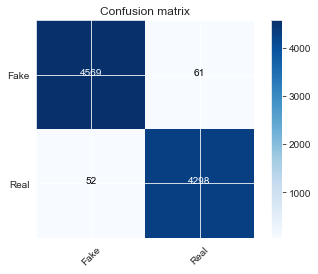

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Decison Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])

# Calculate training time
start = timeit.default_timer()

# Fitting the model
model = pipe.fit(X_train, y_train)

end = timeit.default_timer()

# Accuracy
prediction = model.predict(X_test)


print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

time =  end = start
print("Time:", time)

accuracy: 99.69%
Time: 30.806661958


Confusion matrix, without normalization


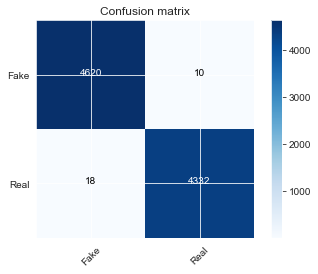

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Random Forest Classifier

In [ ]:

from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

# Calculate training time
start = timeit.default_timer()

model = pipe.fit(X_train, y_train)

end = timeit.default_timer()

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

time = end - start
print("Time:", time)

accuracy: 98.93%
Time: 28.173586999999998


Confusion matrix, without normalization


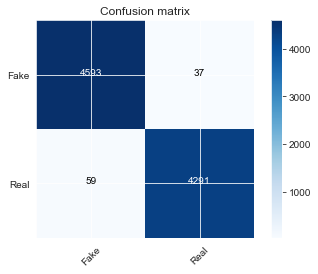

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])